# Set up

In [38]:
import os
import re
import warnings
from pathlib import Path
from typing import Any, Dict, Iterable, List, Tuple

import matplotlib.pyplot as plt
import pandas as pd
import seaborn as sns

from core.CaS.cas_params import CaSParams

sns.set_style("whitegrid")
warnings.simplefilter(action="ignore", category=pd.errors.PerformanceWarning)

MODEL_NAME_MAP = {
    "mlp": "MLP",
    "gcn": "GCN",
    "sage": "SAGE",
    "revgat": "RevGAT",
    "none": "None",
    "mlp_node2vec": "MLP",
}


def get_recas_fn(recas_params: List[Dict[str, Any]]) -> str:
    recas_fn_map = {
        "double_correlation_autoscale": "CS",
        "double_correlation_fixed": "CS",
        "only_outcome_correlation": "S",
        "only_double_correlation_autoscale": "C",
        "only_double_correlation_fixed": "C",
    }
    recas_fn = "".join((recas_fn_map[p["cas_fn"]] for p in recas_params))
    return recas_fn


def read_result_file(
    path: Path, dataset: str, cas_params: CaSParams
) -> Tuple[Dict[str, Any], Dict[str, Any]]:
    model_name = Path(path).stem[len(dataset) + 1 :]

    results_train_only = {
        "feature_type": [],
        "emb": [],
        "cas": [],
        "recas_fn": [],
        "train_acc": [],
        "val_acc": [],
        "test_acc": [],
    }
    results_train_valid = {
        "feature_type": [],
        "emb": [],
        "cas": [],
        "recas_fn": [],
        "train_acc": [],
        "val_acc": [],
        "test_acc": [],
    }
    with open(path) as f:
        # For avoiding duplicate rows for "None" CaS.
        train_only_index_set = set()
        train_valid_index_set = set()
        for line in f:
            match = re.search(
                r"TrainACC: ([0-9\.]+)(?:[^,]+), ValACC: ([0-9\.]+)(?:[^,]+), TestACC: ([0-9\.]+)",
                line,
            )
            if "# Train only" in line:
                results_dict = results_train_only
                index_set = train_only_index_set
            elif "# Train and valid" in line:
                results_dict = results_train_valid
                index_set = train_valid_index_set
            if match:
                train_acc, val_acc, test_acc = map(
                    lambda x: float(x) * 100, match.groups()
                )
                groups = re.search(r"\[(.+?)\]", line).group(1).split("+")
                emb = "None"
                cas = "None"
                if model_name == "none":
                    if len(groups) == 2:
                        _, feature_type = groups
                    else:
                        _, feature_type, cas = groups
                elif "_" in model_name:
                    if len(groups) == 4:
                        _, _, feature_type, emb = groups
                    else:
                        _, _, feature_type, emb, cas = groups
                else:
                    if len(groups) == 3:
                        _, _, feature_type = groups
                    else:
                        _, _, feature_type, cas = groups
                index = (feature_type, emb, cas)
                if index in index_set:
                    continue
                if cas == "C":
                    continue
                cas = "CaS" if cas == "S" else cas
                index_set.add(index)
                results_dict["feature_type"].append(feature_type)
                results_dict["emb"].append(emb)
                results_dict["cas"].append(cas)
                if cas == "CaS":
                    recas_fn = get_recas_fn(
                        [
                            cas_params.get(
                                dataset=dataset,
                                gnn_name=MODEL_NAME_MAP[model_name],
                                feature_type=feature_type,
                                emb=emb,
                            )
                        ]
                    )
                elif cas == "ReCaS":
                    raise ValueError("ReCaS not supported.")
                else:
                    recas_fn = "None"
                results_dict["recas_fn"].append(recas_fn)
                results_dict["train_acc"].append(train_acc)
                results_dict["val_acc"].append(val_acc)
                results_dict["test_acc"].append(test_acc)

    count = len(results_train_only["feature_type"])
    results_train_only["model_name"] = [model_name] * count
    results_train_only["dataset"] = [dataset] * count
    count = len(results_train_valid["feature_type"])
    results_train_valid["model_name"] = [model_name] * count
    results_train_valid["dataset"] = [dataset] * count
    return results_train_only, results_train_valid


def read_result_dir(
    result_dir: Path, cas_params: CaSParams
) -> Tuple[pd.DataFrame, pd.DataFrame]:
    dataset_list = [
        dataset
        for dataset in os.listdir(result_dir)
        if os.path.isdir(result_dir / dataset)
    ]
    train_only_df = pd.DataFrame()
    train_valid_df = pd.DataFrame()
    for dataset in dataset_list:
        dataset_path = result_dir / dataset
        file_list = [
            dataset_path / fname
            for fname in os.listdir(dataset_path)
            if fname.endswith(".txt")
        ]
        for f in file_list:
            train_only_new_df, train_valid_new_df = read_result_file(
                f, dataset, cas_params
            )
            train_only_df = pd.concat([train_only_df, pd.DataFrame(train_only_new_df)])
            train_valid_df = pd.concat(
                [train_valid_df, pd.DataFrame(train_valid_new_df)]
            )
    train_only_df = train_only_df.set_index(
        ["dataset", "model_name", "feature_type", "emb", "cas"]
    )
    train_valid_df = train_valid_df.set_index(
        ["dataset", "model_name", "feature_type", "emb", "cas"]
    )
    return train_only_df, train_valid_df


def reorder_result_df(
    df: pd.DataFrame,
    datasets: List[str] = ["arxiv_2023", "ogbn-arxiv", "cora", "pubmed"],
    model_names: List[str] = ["mlp", "mlp_node2vec", "gcn", "sage", "revgat", "none"],
    feature_types: List[str] = ["Ensemble"],
    cas: List[str] = ["None", "CaS"],
) -> pd.DataFrame:
    """Reorders the result data frame.

    Parameters
    ----------
    df : pd.DataFrame
        The result data frame. The data frame must have the following multi-level index:
        ["dataset", "model_name", "feature_type", "emb", "cas"]
    """
    return df.loc[
        datasets,
        model_names,
        feature_types,
        :,
        cas,
    ]


def select_from_validation(result_df: pd.DataFrame) -> pd.DataFrame:
    """Selects the best method in the result data frame from validation accuracy.

    Parameters
    ----------
    result_df : pd.DataFrame
        The result data frame.
    """
    result_df: pd.DataFrame = reorder_result_df(result_df)
    tmp_df = result_df.reset_index("cas")
    selected_df = pd.DataFrame()
    for index in tmp_df.index.unique():
        loc_df: pd.DataFrame = tmp_df.loc[index]
        cas_df: pd.DataFrame = loc_df[loc_df["cas"] != "None"]
        no_cas_df: pd.DataFrame = loc_df[loc_df["cas"] == "None"]
        cas_df = cas_df.set_index("cas", append=True)
        no_cas_df = no_cas_df.set_index("cas", append=True)
        cas_df = cas_df.loc[[cas_df["val_acc"].idxmax()]]
        selected_df = pd.concat([selected_df, no_cas_df, cas_df])
    return selected_df.sort_index()


def display_df(df: pd.DataFrame):
    with pd.option_context("display.max_rows", None, "display.max_columns", None):
        display(df)

# CaS-CS

In [2]:
cas_params = CaSParams("core/CaS/cas_params_cs.json")
cs_train_only_df, cs_train_valid_df = read_result_dir(Path("results_analysis_cs"), cas_params)

In [3]:
display_df(reorder_result_df(cs_train_only_df))

recas_fn  train_acc  \
dataset    model_name   feature_type emb      cas                        
arxiv_2023 mlp          Ensemble     None     None     None      87.40   
                                              CaS        CS      98.54   
           mlp_node2vec Ensemble     node2vec None     None      88.68   
                                              CaS        CS     100.00   
           gcn          Ensemble     None     None     None      85.14   
                                              CaS        CS      99.98   
           sage         Ensemble     None     None     None      87.97   
                                              CaS        CS     100.00   
           revgat       Ensemble     None     None     None      87.60   
                                              CaS        CS      99.99   
           none         Ensemble     None     None     None      86.46   
                                              CaS        CS      98.32   
ogbn-arxiv mlp          Ensemble     None     None     None      85.08   
                                              CaS        CS      98.41   
           mlp_node2vec Ensemble     node2vec None     None      86.17   
                                              CaS        CS      99.58   
           gcn          Ensemble     None     None     None      80.27   
                                              CaS        CS      98.25   
           sage         Ensemble     None     None     None      84.56   
                                              CaS        CS      99.68   
           revgat       Ensemble     None     None     None      83.52   
                                              CaS        CS      99.06   
           none         Ensemble     None     None     None      85.31   
                                              CaS        CS      99.84   
cora       mlp          Ensemble     None     None     None      96.78   
                                              CaS        CS      99.85   
           mlp_node2vec Ensemble     node2vec None     None      99.62   
                                              CaS        CS     100.00   
           gcn          Ensemble     None     None     None      95.07   
                                              CaS        CS      97.71   
           sage         Ensemble     None     None     None      98.29   
                                              CaS        CS     100.00   
           revgat       Ensemble     None     None     None      97.63   
                                              CaS        CS     100.00   
           none         Ensemble     None     None     None      85.28   
                                              CaS        CS     100.00   
pubmed     mlp          Ensemble     None     None     None      96.49   
                                              CaS        CS     100.00   
           mlp_node2vec Ensemble     node2vec None     None      96.81   
                                              CaS        CS      99.99   
           gcn          Ensemble     None     None     None      95.29   
                                              CaS        CS     100.00   
           sage         Ensemble     None     None     None      97.36   
                                              CaS        CS     100.00   
           revgat       Ensemble     None     None     None      96.98   
                                              CaS        CS     100.00   
           none         Ensemble     None     None     None      97.07   
                                              CaS        CS      99.97   

                                                    val_acc  test_acc  
dataset    model_name   feature_type emb      cas                      
arxiv_2023 mlp          Ensemble     None     None    79.42     79.55  
                                              CaS     78.85     78.90  
           mlp_node2vec Ensemble     node2vec None    79.43   

In [4]:
display_df(reorder_result_df(cs_train_valid_df))

recas_fn  train_acc  \
dataset    model_name   feature_type emb      cas                        
arxiv_2023 mlp          Ensemble     None     None     None      87.40   
                                              CaS        CS      98.37   
           mlp_node2vec Ensemble     node2vec None     None      88.68   
                                              CaS        CS     100.00   
           gcn          Ensemble     None     None     None      85.14   
                                              CaS        CS      99.97   
           sage         Ensemble     None     None     None      87.97   
                                              CaS        CS     100.00   
           revgat       Ensemble     None     None     None      87.60   
                                              CaS        CS      99.98   
           none         Ensemble     None     None     None      86.46   
                                              CaS        CS      98.05   
ogbn-arxiv mlp          Ensemble     None     None     None      85.08   
                                              CaS        CS      98.24   
           mlp_node2vec Ensemble     node2vec None     None      86.17   
                                              CaS        CS      99.52   
           gcn          Ensemble     None     None     None      80.27   
                                              CaS        CS      98.12   
           sage         Ensemble     None     None     None      84.56   
                                              CaS        CS      99.65   
           revgat       Ensemble     None     None     None      83.52   
                                              CaS        CS      98.99   
           none         Ensemble     None     None     None      85.31   
                                              CaS        CS      99.84   
cora       mlp          Ensemble     None     None     None      96.78   
                                              CaS        CS      99.80   
           mlp_node2vec Ensemble     node2vec None     None      99.62   
                                              CaS        CS     100.00   
           gcn          Ensemble     None     None     None      95.07   
                                              CaS        CS      97.37   
           sage         Ensemble     None     None     None      98.29   
                                              CaS        CS     100.00   
           revgat       Ensemble     None     None     None      97.63   
                                              CaS        CS     100.00   
           none         Ensemble     None     None     None      85.28   
                                              CaS        CS     100.00   
pubmed     mlp          Ensemble     None     None     None      96.49   
                                              CaS        CS     100.00   
           mlp_node2vec Ensemble     node2vec None     None      96.81   
                                              CaS        CS      99.99   
           gcn          Ensemble     None     None     None      95.29   
                                              CaS        CS     100.00   
           sage         Ensemble     None     None     None      97.36   
                                              CaS        CS     100.00   
           revgat       Ensemble     None     None     None      96.98   
                                              CaS        CS     100.00   
           none         Ensemble     None     None     None      97.07   
                                              CaS        CS      99.97   

                                                    val_acc  test_acc  
dataset    model_name   feature_type emb      cas                      
arxiv_2023 mlp          Ensemble     None     None    79.42     79.55  
                                              CaS     98.38     78.81  
           mlp_node2vec Ensemble     node2vec None    79.43   

# CaS-S

In [5]:
cas_params = CaSParams("core/CaS/cas_params_s.json")
s_train_only_df, s_train_valid_df = read_result_dir(Path("results_analysis_s"), cas_params)

In [6]:
display_df(reorder_result_df(s_train_only_df))

recas_fn  train_acc  \
dataset    model_name   feature_type emb      cas                        
arxiv_2023 mlp          Ensemble     None     None     None      87.40   
                                              CaS         S     100.00   
           mlp_node2vec Ensemble     node2vec None     None      88.68   
                                              CaS         S     100.00   
           gcn          Ensemble     None     None     None      85.14   
                                              CaS         S      99.99   
           sage         Ensemble     None     None     None      87.97   
                                              CaS         S     100.00   
           revgat       Ensemble     None     None     None      87.60   
                                              CaS         S      99.95   
           none         Ensemble     None     None     None      86.46   
                                              CaS         S     100.00   
ogbn-arxiv mlp          Ensemble     None     None     None      85.08   
                                              CaS         S      95.74   
           mlp_node2vec Ensemble     node2vec None     None      86.17   
                                              CaS         S      97.74   
           gcn          Ensemble     None     None     None      80.27   
                                              CaS         S     100.00   
           sage         Ensemble     None     None     None      84.56   
                                              CaS         S      96.64   
           revgat       Ensemble     None     None     None      83.52   
                                              CaS         S      99.91   
           none         Ensemble     None     None     None      85.31   
                                              CaS         S      99.98   
cora       mlp          Ensemble     None     None     None      96.78   
                                              CaS         S     100.00   
           mlp_node2vec Ensemble     node2vec None     None      99.62   
                                              CaS         S     100.00   
           gcn          Ensemble     None     None     None      95.07   
                                              CaS         S     100.00   
           sage         Ensemble     None     None     None      98.29   
                                              CaS         S     100.00   
           revgat       Ensemble     None     None     None      97.63   
                                              CaS         S      99.55   
           none         Ensemble     None     None     None      85.28   
                                              CaS         S      99.42   
pubmed     mlp          Ensemble     None     None     None      96.49   
                                              CaS         S     100.00   
           mlp_node2vec Ensemble     node2vec None     None      96.81   
                                              CaS         S      99.95   
           gcn          Ensemble     None     None     None      95.29   
                                              CaS         S     100.00   
           sage         Ensemble     None     None     None      97.36   
                                              CaS         S     100.00   
           revgat       Ensemble     None     None     None      96.98   
                                              CaS         S      99.89   
           none         Ensemble     None     None     None      97.07   
                                              CaS         S     100.00   

                                                    val_acc  test_acc  
dataset    model_name   feature_type emb      cas                      
arxiv_2023 mlp          Ensemble     None     None    79.42     79.55  
                                              CaS     79.69     79.89  
           mlp_node2vec Ensemble     node2vec None    79.43   

In [7]:
display_df(reorder_result_df(s_train_valid_df))

recas_fn  train_acc  \
dataset    model_name   feature_type emb      cas                        
arxiv_2023 mlp          Ensemble     None     None     None      87.40   
                                              CaS         S     100.00   
           mlp_node2vec Ensemble     node2vec None     None      88.68   
                                              CaS         S     100.00   
           gcn          Ensemble     None     None     None      85.14   
                                              CaS         S      99.99   
           sage         Ensemble     None     None     None      87.97   
                                              CaS         S     100.00   
           revgat       Ensemble     None     None     None      87.60   
                                              CaS         S      99.95   
           none         Ensemble     None     None     None      86.46   
                                              CaS         S     100.00   
ogbn-arxiv mlp          Ensemble     None     None     None      85.08   
                                              CaS         S      95.64   
           mlp_node2vec Ensemble     node2vec None     None      86.17   
                                              CaS         S      97.71   
           gcn          Ensemble     None     None     None      80.27   
                                              CaS         S     100.00   
           sage         Ensemble     None     None     None      84.56   
                                              CaS         S      96.59   
           revgat       Ensemble     None     None     None      83.52   
                                              CaS         S      99.92   
           none         Ensemble     None     None     None      85.31   
                                              CaS         S      99.97   
cora       mlp          Ensemble     None     None     None      96.78   
                                              CaS         S     100.00   
           mlp_node2vec Ensemble     node2vec None     None      99.62   
                                              CaS         S     100.00   
           gcn          Ensemble     None     None     None      95.07   
                                              CaS         S     100.00   
           sage         Ensemble     None     None     None      98.29   
                                              CaS         S     100.00   
           revgat       Ensemble     None     None     None      97.63   
                                              CaS         S      99.51   
           none         Ensemble     None     None     None      85.28   
                                              CaS         S      98.94   
pubmed     mlp          Ensemble     None     None     None      96.49   
                                              CaS         S     100.00   
           mlp_node2vec Ensemble     node2vec None     None      96.81   
                                              CaS         S      99.95   
           gcn          Ensemble     None     None     None      95.29   
                                              CaS         S     100.00   
           sage         Ensemble     None     None     None      97.36   
                                              CaS         S     100.00   
           revgat       Ensemble     None     None     None      96.98   
                                              CaS         S      99.89   
           none         Ensemble     None     None     None      97.07   
                                              CaS         S     100.00   

                                                    val_acc  test_acc  
dataset    model_name   feature_type emb      cas                      
arxiv_2023 mlp          Ensemble     None     None    79.42     79.55  
                                              CaS    100.00     79.92  
           mlp_node2vec Ensemble     node2vec None    79.43   

# Merge results

In [11]:
merged_df = pd.concat([cs_train_only_df, s_train_only_df]).reset_index().drop_duplicates()
merged_df = merged_df.set_index(["dataset", "model_name", "feature_type", "emb", "cas", "recas_fn"]).sort_index()
merged_df = reorder_result_df(merged_df)
display_df(merged_df)

train_acc  \
dataset    model_name   feature_type emb      cas  recas_fn              
arxiv_2023 mlp          Ensemble     None     None None          87.40   
                                              CaS  CS            98.54   
                                                   S            100.00   
           mlp_node2vec Ensemble     node2vec None None          88.68   
                                              CaS  CS           100.00   
                                                   S            100.00   
           gcn          Ensemble     None     None None          85.14   
                                              CaS  CS            99.98   
                                                   S             99.99   
           sage         Ensemble     None     None None          87.97   
                                              CaS  CS           100.00   
                                                   S            100.00   
           revgat       Ensemble     None     None None          87.60   
                                              CaS  CS            99.99   
                                                   S             99.95   
           none         Ensemble     None     None None          86.46   
                                              CaS  CS            98.32   
                                                   S            100.00   
ogbn-arxiv mlp          Ensemble     None     None None          85.08   
                                              CaS  CS            98.41   
                                                   S             95.74   
           mlp_node2vec Ensemble     node2vec None None          86.17   
                                              CaS  CS            99.58   
                                                   S             97.74   
           gcn          Ensemble     None     None None          80.27   
                                              CaS  CS            98.25   
                                                   S            100.00   
           sage         Ensemble     None     None None          84.56   
                                              CaS  CS            99.68   
                                                   S             96.64   
           revgat       Ensemble     None     None None          83.52   
                                              CaS  CS            99.06   
                                                   S             99.91   
           none         Ensemble     None     None None          85.31   
                                              CaS  CS            99.84   
                                                   S             99.98   
cora       mlp          Ensemble     None     None None          96.78   
                                              CaS  CS            99.85   
                                                   S            100.00   
           mlp_node2vec Ensemble     node2vec None None          99.62   
                                              CaS  CS           100.00   
                                                   S            100.00   
           gcn          Ensemble     None     None None          95.07   
                                              CaS  CS            97.71   
                                                   S            100.00   
           sage         Ensemble     None     None None          98.29   
                                              CaS  CS           100.00   
                                                   S            100.00   
           revgat       Ensemble     None     None None          97.63   
                                              CaS  CS           100.00   
                                                   S             99.55   
           none         Ensemble     None     None None          85.28   
                                              CaS  CS           1

In [25]:
diff_df = merged_df.diff()
diff_df = reorder_result_df(diff_df.loc[:, :, :, :, :, ["CS", "S"]], cas=["CaS"])
diff_df

train_acc  \
dataset    model_name   feature_type emb      cas recas_fn              
arxiv_2023 mlp          Ensemble     None     CaS CS            11.14   
                                                  S              1.46   
           mlp_node2vec Ensemble     node2vec CaS CS            11.32   
                                                  S              0.00   
           gcn          Ensemble     None     CaS CS            14.84   
                                                  S              0.01   
           sage         Ensemble     None     CaS CS            12.03   
                                                  S              0.00   
           revgat       Ensemble     None     CaS CS            12.39   
                                                  S             -0.04   
           none         Ensemble     None     CaS CS            11.86   
                                                  S              1.68   
ogbn-arxiv mlp          Ensemble     None     CaS CS            13.33   
                                                  S             -2.67   
           mlp_node2vec Ensemble     node2vec CaS CS            13.41   
                                                  S             -1.84   
           gcn          Ensemble     None     CaS CS            17.98   
                                                  S              1.75   
           sage         Ensemble     None     CaS CS            15.12   
                                                  S             -3.04   
           revgat       Ensemble     None     CaS CS            15.54   
                                                  S              0.85   
           none         Ensemble     None     CaS CS            14.53   
                                                  S              0.14   
cora       mlp          Ensemble     None     CaS CS             3.07   
                                                  S              0.15   
           mlp_node2vec Ensemble     node2vec CaS CS             0.38   
                                                  S              0.00   
           gcn          Ensemble     None     CaS CS             2.64   
                                                  S              2.29   
           sage         Ensemble     None     CaS CS             1.71   
                                                  S              0.00   
           revgat       Ensemble     None     CaS CS             2.37   
                                                  S             -0.45   
           none         Ensemble     None     CaS CS            14.72   
                                                  S             -0.58   
pubmed     mlp          Ensemble     None     CaS CS             3.51   
                                                  S              0.00   
           mlp_node2vec Ensemble     node2vec CaS CS             3.18   
                                                  S             -0.04   
           gcn          Ensemble     None     CaS CS             4.71   
                                                  S              0.00   
           sage         Ensemble     None     CaS CS             2.64   
                                                  S              0.00   
           revgat       Ensemble     None     CaS CS             3.02   
                                                  S             -0.11   
           none         Ensemble     None     CaS CS             2.90   
                                                  S              0.03   

                                                            val_acc  test_acc  
dataset    model_name   feature_type emb      cas recas_fn                     
arxiv_2023 mlp          Ensemble     None     CaS CS          -0.57     -0.65  
                                                  S            0.84      0.99  
           mlp_node2vec Ensemble     node2vec CaS CS           0.48      0.53  
         

In [35]:
show_df

Base predictor  Method  train_acc  \
dataset    feature_type emb      cas                                     
arxiv_2023 Ensemble     None     CaS            mlp     C&S      11.14   
                                 CaS            mlp  only S       1.46   
                        node2vec CaS   mlp_node2vec     C&S      11.32   
                                 CaS   mlp_node2vec  only S       0.00   
                        None     CaS            gcn     C&S      14.84   
                                 CaS            gcn  only S       0.01   
                                 CaS           sage     C&S      12.03   
                                 CaS           sage  only S       0.00   
                                 CaS         revgat     C&S      12.39   
                                 CaS         revgat  only S      -0.04   
                                 CaS           none     C&S      11.86   
                                 CaS           none  only S       1.68   
ogbn-arxiv Ensemble     None     CaS            mlp     C&S      13.33   
                                 CaS            mlp  only S      -2.67   
                        node2vec CaS   mlp_node2vec     C&S      13.41   
                                 CaS   mlp_node2vec  only S      -1.84   
                        None     CaS            gcn     C&S      17.98   
                                 CaS            gcn  only S       1.75   
                                 CaS           sage     C&S      15.12   
                                 CaS           sage  only S      -3.04   
                                 CaS         revgat     C&S      15.54   
                                 CaS         revgat  only S       0.85   
                                 CaS           none     C&S      14.53   
                                 CaS           none  only S       0.14   
cora       Ensemble     None     CaS            mlp     C&S       3.07   
                                 CaS            mlp  only S       0.15   
                        node2vec CaS   mlp_node2vec     C&S       0.38   
                                 CaS   mlp_node2vec  only S       0.00   
                        None     CaS            gcn     C&S       2.64   
                                 CaS            gcn  only S       2.29   
                                 CaS           sage     C&S       1.71   
                                 CaS           sage  only S       0.00   
                                 CaS         revgat     C&S       2.37   
                                 CaS         revgat  only S      -0.45   
                                 CaS           none     C&S      14.72   
                                 CaS           none  only S      -0.58   
pubmed     Ensemble     None     CaS            mlp     C&S       3.51   
                                 CaS            mlp  only S       0.00   
                        node2vec CaS   mlp_node2vec     C&S       3.18   
                                 CaS   mlp_node2vec  only S      -0.04   
                        None     CaS            gcn     C&S       4.71   
                                 CaS            gcn  only S       0.00   
                                 CaS           sage     C&S       2.64   
                                 CaS           sage  only S       0.00   
                                 CaS         revgat     C&S       3.02   
                                 CaS         revgat  only S      -0.11   
                                 CaS           none     C&S       2.90   
                                 CaS           none  only S       0.03   

                                      val_acc  Accuracy improvement (%)  
dataset    feature_type emb      cas                                     
arxiv_2023 Ensemble     None     CaS    -0.57                     -0.65  
                                 CaS     0.84                      0.99  
                        node2vec CaS    

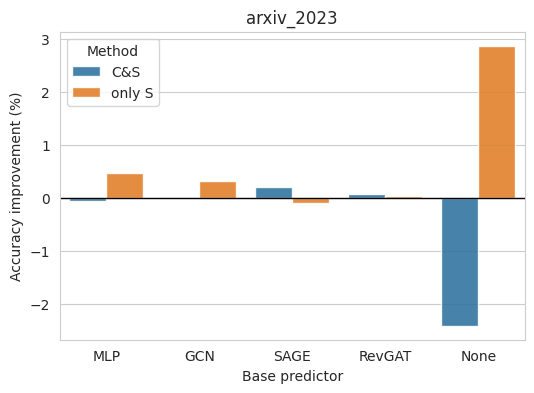

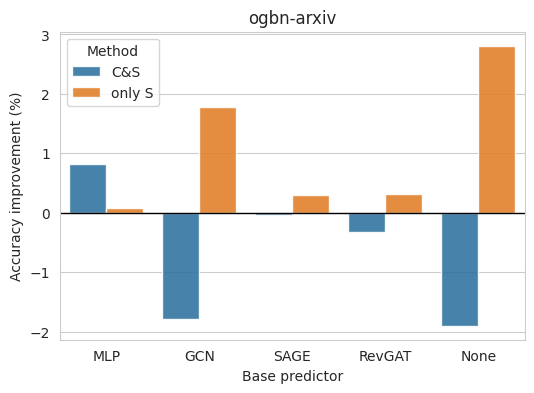

In [49]:
show_df = diff_df.reset_index(["model_name", "recas_fn"]).rename(columns={"model_name": "Base predictor", "test_acc": "Accuracy improvement (%)", "recas_fn": "Method"})
show_df["Method"] = show_df["Method"].map({"CS": "C&S", "S": "only S"}.__getitem__)
show_df["Base predictor"] = show_df["Base predictor"].map(MODEL_NAME_MAP.__getitem__)
for dataset in ("arxiv_2023", "ogbn-arxiv"):
    plt.figure(figsize=(6, 4))
    ax = sns.barplot(show_df.loc[dataset], x="Base predictor", y="Accuracy improvement (%)", hue="Method", errorbar=None, alpha=0.9)
    ax.axhline(0, lw=1, color='black')
    ax.set_title(dataset)
    plt.show()